In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load dataset
# train_path = "/kaggle/input/off-dataset/train.json"
# test_path = "/kaggle/input/off-dataset/test.json"

train_path = r"D:\major project\nepali-offensive-lang-detection-dataset\train.json"
test_path = r"D:\major project\nepali-offensive-lang-detection-dataset\test.json"

train_df = pd.read_json(train_path)
test_df = pd.read_json(test_path)


# Show basic structure
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nSample data train:\n")
train_df.head()






Train shape: (5798, 4)
Test shape: (1450, 4)

Sample data train:



,ID,Comment,Label_Binary,Label_Multiclass
0,vumtps,आज जीउदै छौ कसलाई के थाहा छ र भोली जीउदै भईन्छ...,NOFF,NO
1,zrqopi,अटल बीहारी अवीवाहीत थीए छोरी कहाँ बाट हून्छ भन...,OFF,OR
2,iizffd,जरुरि छ / नेपालको पोलिटिकल सिस्टम ले गर्दा तिम...,NOFF,NO
3,yadmpv,मान्छे मात्र होइन गाउँ तिर भैसी ब्याउने समय पन...,NOFF,NO
4,tggjjt,सरलार जनतालाइ देखाउन आफ्नो फोटो बीजूलीको पोलमा...,OFF,OO


In [19]:
print(train_df.head())

       ID                                            Comment Label_Binary  \
0  vumtps  आज जीउदै छौ कसलाई के थाहा छ र भोली जीउदै भईन्छ...         NOFF   
1  zrqopi  अटल बीहारी अवीवाहीत थीए छोरी कहाँ बाट हून्छ भन...          OFF   
2  iizffd  जरुरि छ / नेपालको पोलिटिकल सिस्टम ले गर्दा तिम...         NOFF   
3  yadmpv  मान्छे मात्र होइन गाउँ तिर भैसी ब्याउने समय पन...         NOFF   
4  tggjjt  सरलार जनतालाइ देखाउन आफ्नो फोटो बीजूलीको पोलमा...          OFF   

  Label_Multiclass  
0               NO  
1               OR  
2               NO  
3               NO  
4               OO  


In [20]:
from sklearn.model_selection import train_test_split
# Create validation set (10–15% split from train set)
train_df, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df["Label_Multiclass"], random_state=42
)

print(f"\nNew train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


New train size: 4928, Validation size: 870, Test size: 1450


In [21]:
# ! pip install gensim==4.3.1
# ! pip install emoji


In [1]:
import re
import emoji
import pandas as pd
import numpy as np
import regex as regex
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:


# --- Setup ---
nepali_stopwords = set([
    "र", "मा", "कि", "भने", "त", "छ", "हो", "लाई", "ले",
    "गरेको", "गर्छ", "गर्छन्", "हुन्", "गरे", "न", "नभएको"
])

dirghikaran_map = {
    # Vowel elongations / replacements (typical dirghikaran)
    "उ": "ऊ",
    "इ": "ई",
    "ऋ": "रि",  # Often replaced this way in Nepali
    "ए": "ऐ",   # More natural elongated vowel
    "अ": "आ",   # If you want to normalize short 'a' to long 'aa'

    # Remove zero-width joiner/non-joiner
    "\u200d": "",
    "\u200c": "",

    # Normalize punctuation marks
    "।": ".",
    "॥": ".",

    # Common vowel signs normalization (optional)
    "ि": "ी",
    "ु": "ू"
}


roman_stopwords = None  # Will be initialized below

# --- Helper Functions ---

def is_devanagari(text: str) -> bool:
    """Detect if text contains any Devanagari characters."""
    return bool(regex.search(r'\p{Devanagari}', text))

def devanagari_to_roman(text: str) -> str:
    try:
        return transliterate(text, sanscript.DEVANAGARI, sanscript.ITRANS)
    except Exception:
        return text

def roman_to_devanagari(text: str) -> str:
    try:
        return transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)
    except Exception:
        return text

def normalize_dirghikaran(text: str) -> str:
    for original, replacement in dirghikaran_map.items():
        text = text.replace(original, replacement)
    return text


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)         # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)              # Remove mentions/hashtags
    text = re.sub(r"\d+", "", text)                    # Remove numbers
    text = emoji.replace_emoji(text, replace="")      # Remove emojis
    text = re.sub(r"[^\w\s]", "", text)                # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()           # Normalize whitespace
    return text

def clean_text_for_transformer(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove URLs, emojis, and excessive whitespace
    text = re.sub(r"http\S+|www\S+", "", text)
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text).strip()
    return text


def remove_stopwords_devanagari(text: str) -> str:
    """Remove Devanagari stopwords from text."""
    return ' '.join([word for word in text.split() if word not in nepali_stopwords])

def remove_stopwords_roman(text: str) -> str:
    """Remove Romanized stopwords from text."""
    global roman_stopwords
    if roman_stopwords is None:
        # Initialize roman_stopwords lazily to avoid dependency issues
        roman_stopwords = set([devanagari_to_roman(w) for w in nepali_stopwords])
    return ' '.join([word for word in text.split() if word not in roman_stopwords])

# --- Preprocessing Pipelines ---

def preprocess_for_ml_dl(text: str) -> str:
    """
    Preprocess input text for ML/GRU baselines:
    - Remove stopwords (script dependent)
    - Transliterate Devanagari → Roman
    - Clean Roman text
    """
    if not isinstance(text, str):
        return ""

    if is_devanagari(text):
        text = clean_text(text)
        text = remove_stopwords_devanagari(text)
        text = devanagari_to_roman(text)
    else:
        text = clean_text(text)
        text = remove_stopwords_roman(text)

    return text

def preprocess_for_transformer(text: str) -> str:
    """
    Preprocess input text for Transformer (XLM-Roberta):
    - Transliterate Roman → Devanagari if needed
    - Light cleaning only (no normalization, no punctuation stripping)
    """
    if not isinstance(text, str):
        return ""
    
    if not is_devanagari(text):
        text = roman_to_devanagari(text)

    text = clean_text_for_transformer(text)
    return text


# ----------- Apply Preprocessing to Dataset -----------

for df in [train_df, val_df, test_df]:
    # ML/GRU input: Romanized, cleaned, stopword-removed
    df["clean_comment"] = df["Comment"].apply(preprocess_for_ml_dl)
    df["tokens"] = df["clean_comment"].apply(str.split)

    # Transformer input: Devanagari, normalized, lightly cleaned
    df["transformer_input"] = df["Comment"].apply(preprocess_for_transformer)

# ----------- Inspect Preprocessing on Samples -----------
print("🔍 Sample Preprocessed Outputs:\n")
for idx, row in train_df[["Comment", "clean_comment", "transformer_input"]].head(10).iterrows():
    print(f"📝 Original       : {row['Comment']}")
    print(f"📊 ML/GRU Cleaned : {row['clean_comment']}")
    print(f"🤖 XLM-R Input    : {row['transformer_input']}")
    print("-" * 60)


🔍 Sample Preprocessed Outputs:

📝 Original       : भीखारी कांग्रेस का दलाल
📊 ML/GRU Cleaned : bhakhara kagarasa ka dalala
🤖 XLM-R Input    : भीखारी कांग्रेस का दलाल
------------------------------------------------------------
📝 Original       : फील्म हलमा दाईं तपाईंको टाउकोले छेक्यो भन्ने ठीटी फीट छ हाइट तेरो अर्को पाली देखी आफनो औकात हेरेर सीट ली बूझीस् अझै मूजी ईङलीस छाड्छ
📊 ML/GRU Cleaned : phalama halama daI tapaIka Taukala Chakaya bhanana ThaTa phaTa haiTa tara araka pala dakha Aphana aukata harara saTa la bajhasa ajha maja I~Nalasa ChaDaCha
🤖 XLM-R Input    : फील्म हलमा दाईं तपाईंको टाउकोले छेक्यो भन्ने ठीटी फीट छ हाइट तेरो अर्को पाली देखी आफनो औकात हेरेर सीट ली बूझीस् अझै मूजी ईङलीस छाड्छ
------------------------------------------------------------
📝 Original       : हैट बिदेस मा नि राजनिती पढेलेखेका मान्छे त झन positive खराव हुन्छ्न होला किन त सहिला सोधेर मार्‍यो
📊 ML/GRU Cleaned : haTa badasa ma rajanata paDhalakhaka manaCha jhana positive kharava hanaChana hala kana sahala sa

In [24]:
train_df.head(2)

,ID,Comment,Label_Binary,Label_Multiclass,clean_comment,tokens,transformer_input
3670,pqlvty,भीखारी कांग्रेस का दलाल,OFF,OO,bhakhara kagarasa ka dalala,"[bhakhara, kagarasa, ka, dalala]",भीखारी कांग्रेस का दलाल
3587,dbtslw,फील्म हलमा दाईं तपाईंको टाउकोले छेक्यो भन्ने ठ...,OFF,OO,phalama halama daI tapaIka Taukala Chakaya bha...,"[phalama, halama, daI, tapaIka, Taukala, Chaka...",फील्म हलमा दाईं तपाईंको टाउकोले छेक्यो भन्ने ठ...


In [25]:
# -------------------------
# ML Baseline Pipeline
# -------------------------

def train_evaluate_ml_baselines(train_df, val_df, test_df):
    # Extract the text (features) and labels (targets) from train, validation, and test sets
    X_train_texts = train_df["clean_comment"]
    X_val_texts = val_df["clean_comment"]
    X_test_texts = test_df["clean_comment"]

    y_train = train_df["Label_Multiclass"]
    y_val = val_df["Label_Multiclass"]
    y_test = test_df["Label_Multiclass"]

    # Convert text into TF-IDF feature vectors (using unigrams, bigrams, trigrams)
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_val = vectorizer.transform(X_val_texts)
    X_test = vectorizer.transform(X_test_texts)

    # Encode class labels into numeric values (needed for sklearn classifiers)
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    # Compute class weights to handle class imbalance in Logistic Regression and SVM
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_enc), y=y_train_enc)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    # Apply SMOTE to handle class imbalance (only for Naive Bayes, which doesn't accept class_weight)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train_enc)

    # Define the baseline ML models:
    models = {
        "Logistic Regression (weighted)": LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42),
        "Support Vector Machine (weighted)": LinearSVC(class_weight=class_weight_dict, random_state=42),
        "Naive Bayes (SMOTE balanced)": MultinomialNB()
    }

    # Function to evaluate a model using classification report and confusion matrix
    def evaluate_model(model, X, y_true_enc, name):
        preds = model.predict(X)
        print(f"\n=== {name} ===")
        print(classification_report(y_true_enc, preds, target_names=le.classes_))
        
        # Display confusion matrix for better class-wise performance visualization
        cm = confusion_matrix(y_true_enc, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    # Loop through each model and train + evaluate
    for name, model in models.items():
        if "Naive Bayes" in name:
            # Train Naive Bayes on SMOTE-balanced data
            model.fit(X_train_res, y_train_res)
            evaluate_model(model, X_val, y_val_enc, name)
        else:
            # Train other models on original (but class-weighted) data
            model.fit(X_train, y_train_enc)
            evaluate_model(model, X_val, y_val_enc, name)


In [26]:
# -------------------------
# GRU Model Components
# -------------------------

# PyTorch Dataset class to wrap the data for use in DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids  # list of tokenized & encoded inputs
        self.labels = labels        # list of encoded labels

    def __len__(self):
        return len(self.input_ids)  # total number of samples

    def __getitem__(self, idx):
        # returns a dictionary containing the input and corresponding label as tensors
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Function to convert tokens into index values and pad/truncate them to a fixed max length
def encode_and_pad(tokens, word2idx, max_len=100):
    # Map each token to its corresponding index in the vocabulary, unknowns → 0
    indices = [word2idx.get(tok, 0) for tok in tokens]
    
    # Pad or truncate the sequence to fixed length
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices += [0] * (max_len - len(indices))  # pad with zeros

    return indices #  Purpose: Converts variable-length token sequences into fixed-length vectors for model input

# GRU-based Classifier using PyTorch
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout=0.3):
        super(GRUClassifier, self).__init__()

        num_embeddings, embedding_dim = embedding_matrix.shape

        # Pre-trained embedding layer, trainable
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.embedding_dropout = nn.Dropout(dropout)  # prevent overfitting

        # Bi-directional GRU with 2 layers
       # Takes sequences of embedded word vectors.
       # Processes both forward and backward sequences.
       
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True,
                          dropout=dropout, bidirectional=True, num_layers=2)

        # Normalize hidden state before FC layer
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer to map GRU output to number of classes
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding_dropout(self.embedding(x))  # [batch_size, seq_len, emb_dim]
        _, hidden = self.gru(embedded)  # [num_layers*2, batch_size, hidden_dim]

        # Concatenate last forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.layer_norm(hidden)
        return self.fc(self.dropout(hidden))  # final logits for classification

# Optional label smoothing loss function (used to soften hard targets; not enabled in training)
# Adds a small amount of uncertainty to true labels, reducing overconfidence in predictions.
# def label_smoothing_loss(preds, targets, smoothing=0.1):
#     confidence = 1.0 - smoothing
#     log_probs = torch.nn.functional.log_softmax(preds, dim=-1)
#     n_classes = preds.size(1)
    
#     # One-hot vector for true class
#     true_dist = torch.zeros_like(log_probs).scatter_(1, targets.unsqueeze(1), confidence)
#     true_dist += smoothing / n_classes  # distribute remaining prob to other classes
#     return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

# Main function to train the GRU model
def train_gru_model(train_df, val_df, test_df, embedding_matrix, word2idx, le, epochs=20, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encode text tokens to fixed-length index sequences
    for df in [train_df, val_df, test_df]:
        df["input_ids"] = df["tokens"].apply(lambda x: encode_and_pad(x, word2idx, max_len=50))

    # Encode class labels using label encoder
    y_train = le.transform(train_df["Label_Multiclass"])
    y_val = le.transform(val_df["Label_Multiclass"])
    y_test = le.transform(test_df["Label_Multiclass"])

    # Convert dataframes to PyTorch datasets
    train_dataset = HateSpeechDataset(train_df["input_ids"].tolist(), y_train)
    val_dataset = HateSpeechDataset(val_df["input_ids"].tolist(), y_val)
    test_dataset = HateSpeechDataset(test_df["input_ids"].tolist(), y_test)

    # Loaders for batch processing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Compute class weights for imbalanced dataset and pass to loss function
    # Computes weights inversely proportional to class frequency.
   #  Passed to the loss function to reduce bias toward majority classes.
   
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Initialize model, optimizer, scheduler and loss function
    model = GRUClassifier(embedding_matrix, hidden_dim=128, output_dim=len(le.classes_)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # handles class imbalance

    best_val_loss = float('inf')  # for early stopping
    patience = 3  # stop if no improvement in 3 epochs
    trigger_times = 0

    train_loss_hist, val_loss_hist = [], []

    # ------------- Training Loop -------------
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # prevent gradient explosion
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_hist.append(avg_train_loss)

        # -------- Validation Phase --------
        model.eval()
        val_loss, correct, total = 0, 0, 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_loss_hist.append(avg_val_loss)
        val_acc = correct / total
        val_f1 = f1_score(val_targets, val_preds, average='macro')

        # Print epoch summary
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Step the learning rate scheduler
        scheduler.step(avg_val_loss)

        # -------- Early Stopping Check --------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0

            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch
            }, "best_gru_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    # --------- Plot Training/Validation Loss Curves ---------
    plt.plot(train_loss_hist, label="Train Loss")
    plt.plot(val_loss_hist, label="Val Loss")
    plt.title("GRU Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true_enc, y_pred_enc, class_labels):
    """
    Prints the classification report and confusion matrix as a formatted table in terminal.

    Args:
        y_true_enc (array-like): True encoded labels.
        y_pred_enc (array-like): Predicted encoded labels.
        class_labels (list): List of class names in order corresponding to labels.
    """
    # print(classification_report(y_true_enc, y_pred_enc, target_names=class_labels))
    
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    cm_df = pd.DataFrame(cm, index=[f"Actual {c}" for c in class_labels],
                         columns=[f"Predicted {c}" for c in class_labels])
    print("\nConfusion Matrix:")
    print(cm_df)


def train_evaluate_ml_baselines(train_df, val_df, test_df):
    # Extract text features and labels
    X_train_texts = train_df["clean_comment"]
    X_val_texts = val_df["clean_comment"]
    X_test_texts = test_df["clean_comment"]

    y_train = train_df["Label_Multiclass"]
    y_val = val_df["Label_Multiclass"]
    y_test = test_df["Label_Multiclass"]

    # TF-IDF vectorization (unigrams, bigrams, trigrams)
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_val = vectorizer.transform(X_val_texts)
    X_test = vectorizer.transform(X_test_texts)

    # Label encoding
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    # Compute class weights for Logistic Regression and SVM
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_enc), y=y_train_enc)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    # SMOTE for Naive Bayes (which doesn't accept class weights)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train_enc)

    # Define baseline models
    models = {
        "Logistic Regression (weighted)": LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42),
        "Support Vector Machine (weighted)": LinearSVC(class_weight=class_weight_dict, random_state=42),
        "Naive Bayes (SMOTE balanced)": MultinomialNB()
    }

    def evaluate_model_with_plot(model, X, y_true_enc, name):
        preds = model.predict(X)
        print(f"\n=== {name} ===")
        print(classification_report(y_true_enc, preds, target_names=le.classes_))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_true_enc, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    def evaluate_model_with_text(model, X, y_true_enc, name):
        preds = model.predict(X)
        print(f"\n=== {name} ===")
        print_confusion_matrix(y_true_enc, preds, le.classes_)

    # Choose which evaluation method to use:
    # Set to True to use plot, False to use terminal print
    use_plot = False

    for name, model in models.items():
        if "Naive Bayes" in name:
            model.fit(X_train_res, y_train_res)
        else:
            model.fit(X_train, y_train_enc)

        if use_plot:
            evaluate_model_with_plot(model, X_val, y_val_enc, name)
        else:
            evaluate_model_with_text(model, X_val, y_val_enc, name)


# ---------------------------
# Example usage:
# ---------------------------
print("\n✅ Training ML Baseline Models...")
train_evaluate_ml_baselines(train_df, val_df, test_df)



✅ Training ML Baseline Models...

=== Logistic Regression (weighted) ===
              precision    recall  f1-score   support

          NO       0.82      0.83      0.82       534
          OO       0.68      0.61      0.65       293
          OR       0.40      0.61      0.48        33
          OS       0.20      0.40      0.27        10

    accuracy                           0.74       870
   macro avg       0.53      0.61      0.55       870
weighted avg       0.75      0.74      0.74       870



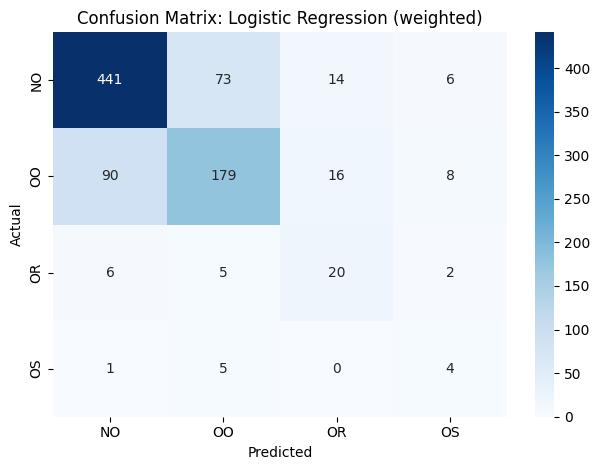

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



=== Support Vector Machine (weighted) ===
              precision    recall  f1-score   support

          NO       0.80      0.84      0.82       534
          OO       0.68      0.62      0.65       293
          OR       0.46      0.48      0.47        33
          OS       0.08      0.10      0.09        10

    accuracy                           0.74       870
   macro avg       0.51      0.51      0.51       870
weighted avg       0.74      0.74      0.74       870



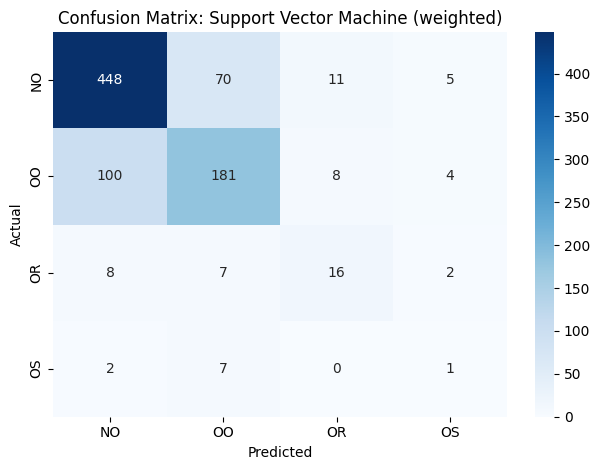


=== Naive Bayes (SMOTE balanced) ===
              precision    recall  f1-score   support

          NO       0.81      0.71      0.76       534
          OO       0.64      0.50      0.56       293
          OR       0.17      0.52      0.26        33
          OS       0.08      0.60      0.14        10

    accuracy                           0.63       870
   macro avg       0.43      0.58      0.43       870
weighted avg       0.72      0.63      0.67       870



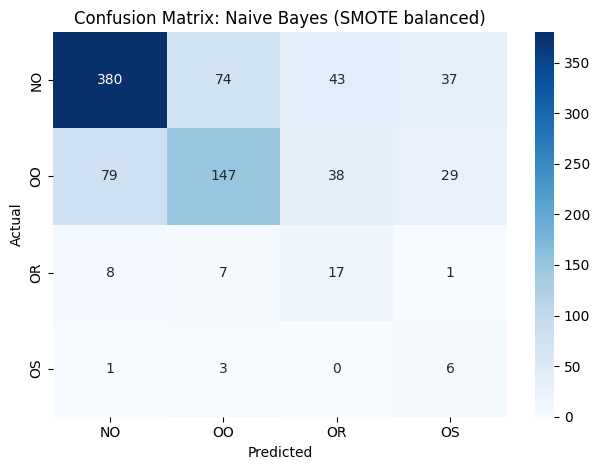

In [27]:
from gensim.models import Word2Vec

# ----------- ML Baselines -----------
print("\n✅ Training ML Baseline Models...")
train_evaluate_ml_baselines(train_df, val_df, test_df)






🔤 Building Vocabulary and Embeddings...

🧠 Training GRU Model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 1.4545, Val Loss: 1.3790, Val Acc: 0.4080, Val F1: 0.2151
Epoch 2, Train Loss: 1.4374, Val Loss: 1.3935, Val Acc: 0.4494, Val F1: 0.2545
Epoch 3, Train Loss: 1.4344, Val Loss: 1.3619, Val Acc: 0.4759, Val F1: 0.2792
Epoch 4, Train Loss: 1.4307, Val Loss: 1.3623, Val Acc: 0.5598, Val F1: 0.3101
Epoch 5, Train Loss: 1.4182, Val Loss: 1.3522, Val Acc: 0.4230, Val F1: 0.2251
Epoch 6, Train Loss: 1.3833, Val Loss: 1.3514, Val Acc: 0.5517, Val F1: 0.2653
Epoch 7, Train Loss: 1.3735, Val Loss: 1.3474, Val Acc: 0.5069, Val F1: 0.2992
Epoch 8, Train Loss: 1.4012, Val Loss: 1.3379, Val Acc: 0.4839, Val F1: 0.2873
Epoch 9, Train Loss: 1.3636, Val Loss: 1.3283, Val Acc: 0.5989, Val F1: 0.3107
Epoch 10, Train Loss: 1.3494, Val Loss: 1.3431, Val Acc: 0.5885, Val F1: 0.2800


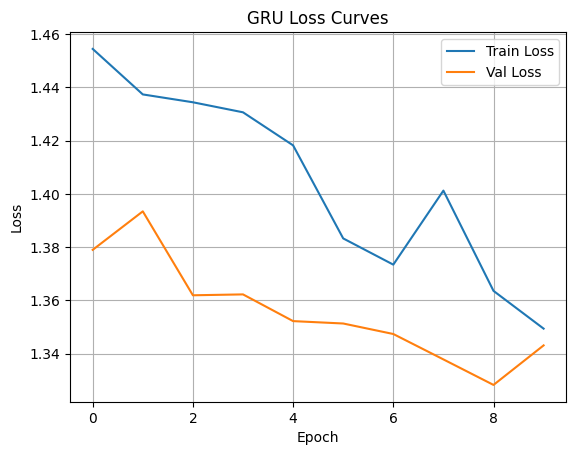

In [ ]:
# ----------- GRU Model Preparation -----------
print("\n🔤 Building Vocabulary and Embeddings...")

# Train Word2Vec embeddings on tokenized training data
# Converts each word into a 100-dimensional vector.
all_tokens = train_df["tokens"].tolist()
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=2, workers=4)

# Build vocab dictionary with index offset (1-based indexing)
vocab = {word: idx+1 for idx, word in enumerate(w2v_model.wv.index_to_key)}
vocab["<UNK>"] = 0  # unknown token index = 0

# Create embedding matrix using Word2Vec vectors
embedding_matrix = np.zeros((len(vocab), 100))
for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

# Encode multiclass labels
le = LabelEncoder()
le.fit(train_df["Label_Multiclass"])

# Train the model
print("\n🧠 Training GRU Model...")
train_gru_model(train_df, val_df, test_df, embedding_matrix, vocab, le)
